<a href="https://colab.research.google.com/github/LongNguyen1984/GANLearning/blob/main/AC_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install tensorflow_addon

In [2]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [2]:
from random import random
import os
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy import expand_dims
from numpy.random import randint
from numpy.random import randn
from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Flatten, Dropout, Dense, Reshape
#import tensorflow_addons as tfa
from tensorflow.keras.layers import Embedding
from matplotlib import pyplot

In [3]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
  # weigth initialization
  init = RandomNormal(stddev=0.02)
  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # linear multiplication
  n_nodes = 7*7
  li = Dense(n_nodes, kernel_initializer=init)(li)
  # reshape to additional channel
  li = Reshape((7,7,1))(li)
  # image_input, foudation for 7*7 image
  in_lat = Input(shape = latent_dim)
  n_nodes = 384*7*7
  g = Dense(n_nodes, kernel_initializer=init)(in_lat)
  g = Activation('relu')(g) 
  #g = LeakyReLU(alpha=0.2)(gen)
  g = Reshape((7,7,384))(g)

  # merge image gen and label input, have a shape (7,7,384+1)
  merge = Concatenate()([g,li])
  # Upsample to 14x14
  g = Conv2DTranspose(192, (5,5), strides=(2,2),padding='same', kernel_initializer=init)(merge)
  g = BatchNormalization()(g)
  g = Activation('relu')(g)
  #gen = LeakyReLU(alpha=0.2)(gen)
  # Upsample to 28x28
  g = Conv2DTranspose(1,(5,5), strides=(2,2),padding='same', kernel_initializer=init)(g)
  #g = LeakyReLU(alpha=0.2)(gen)
  # generate
  #g = Conv2DTranspose(1, (7,7), padding='same', kernel_initializer=init)(gen)
  output = Activation('tanh')(g)
  # define model
  model = Model([in_lat, in_label], output)
  return model

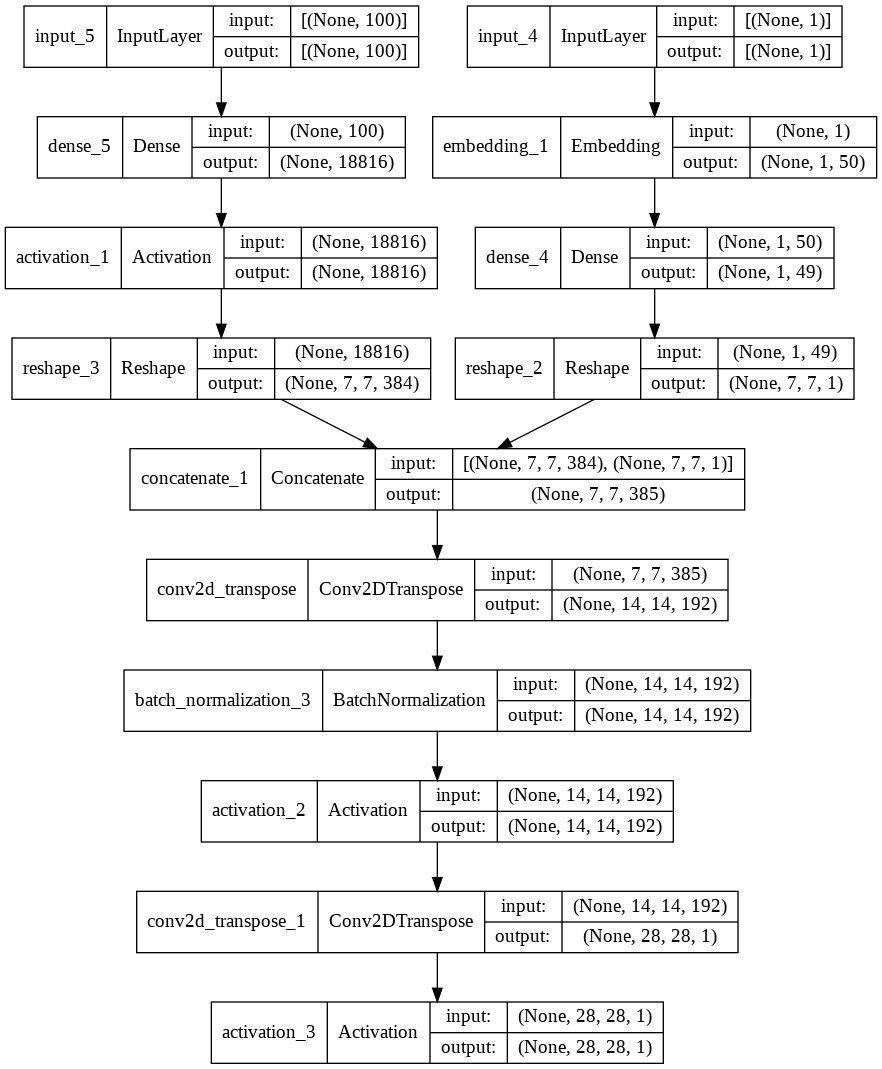

In [11]:
from keras.utils.vis_utils import plot_model
latent_dim =100
g_model = define_generator(latent_dim=latent_dim)


plot_model(g_model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

In [4]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # image input
  in_image = Input(shape=in_shape)
  # down sample to 14x14
  fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.5)(fe)
  # Normal
  fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
  fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.5)(fe)
  # downsample to 7x7
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
  fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.5)(fe)
  # Normal
  fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
  fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.5)(fe)
  # flatten feature maps
  fe = Flatten()(fe)
  # real/fake output
  out1 = Dense(1, activation='sigmoid')(fe)
  # class label output
  out2 = Dense(n_classes, activation='softmax')(fe)
  # define model
  model = Model(in_image, [out1, out2])
  # compile model
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
  return model

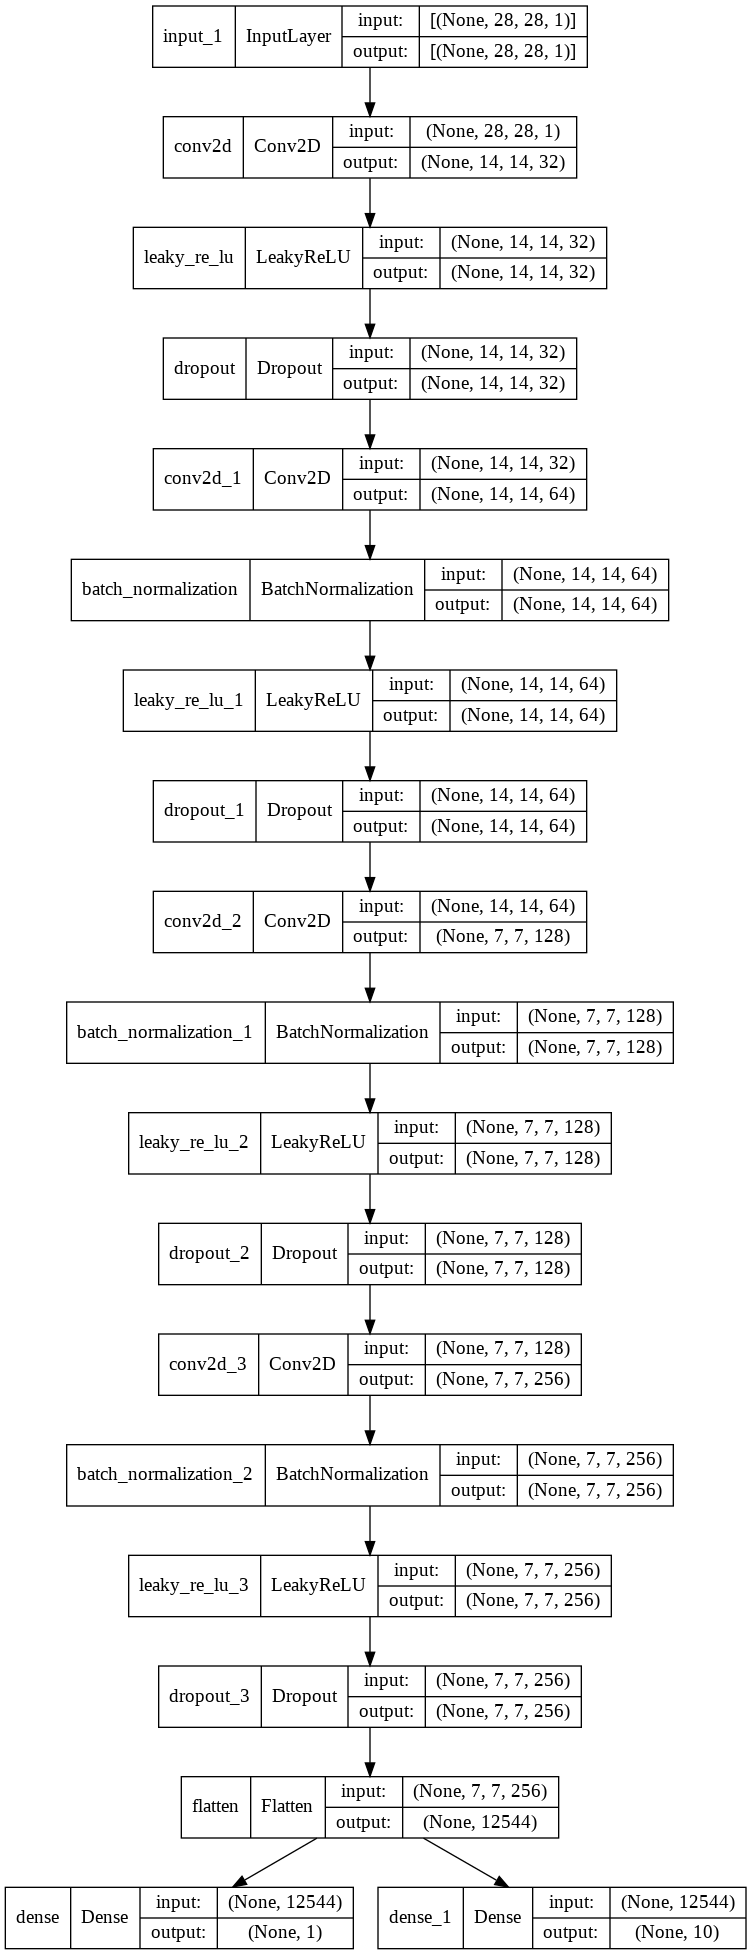

In [8]:
from keras.utils.vis_utils import plot_model

d_model = define_discriminator()
plot_model(d_model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weigths in the discriminator not trainable
  d_model.trainable = False
    # get image output from the generator model
  gen_output = g_model.output
  # connect image output and label input from generator as inputs to discriminator
  gan_output = d_model(gen_output)
  # define gan model as taking latent vector and label and outputting a classification
  model = Model(g_model.input, gan_output)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
  return model


## Training the model


In [9]:
# load fashion mnist images
def load_real_samples():
  # load dataset
  (trainX, trainy), (_,_) = load_data()
  # expand to 3d, e.g. add channels
  X = expand_dims(trainX, axis=-1)
  # convert from ints to floats
  X = X.astype('float32')
  # scale from [0, 255] to [-1, 1]
  X = (X - 127.5)/127.5
  print(X.shape, trainy.shape)
  return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
  # split into images and labels
  images, labels = dataset
  # choose random instances
  ix = randint(0, images.shape[0], n_samples)
  # select images and labels
  X, labels = images[ix], labels[ix]
  # generate class labels
  y = ones((n_samples, 1))
  return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  # generate points in the latent space
  x_input = randn(latent_dim*n_samples)
  # reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = randint(0, n_classes, n_samples)
  return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
  # generate points in latent space
  z_input, labels_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  images = generator.predict([z_input, labels_input])
  # create class labels
  y = zeros((n_samples, 1))
  return [images, labels_input], y
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
  # prepare fake examples
  [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
  # scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0
  # plot images
  for i in range(100):
    # define subplot
    pyplot.subplot(10, 10, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
  filename1 = 'generated_plot_%04d.png' % (step+1)
  pyplot.savefig(filename1)
  pyplot.close()
  # save the generator model
  filename2 = 'model_%04d.h5' % (step+1)
  g_model.save(filename2)
  print('>Saved: %s and %s' % (filename1, filename2))
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset[0].shape[0]/n_batch)
  half_batch = int(n_batch/2)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  # manually enumerate epochs
  for i in range(n_steps):
    # get randomly selected 'real' samples
    [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
    # update discriminator model weights
    d_r,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
    # generate 'fake' examples
    [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator model weights
    d_f,d_f1,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
    # prepare points in latent space as input for the generator
    [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))
    # update the generator via the discriminator's error
    _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
      # summarise loss in this batch
    print('>%d, dr[%.3f, %.3f, %.3f], df[%.3f, %.3f,%.3f], g[%.3f, %.3f]' % (i+1,d_r, d_r1, d_r2,d_f, d_f1, d_f2, g_1,g_2))
    # seve the generator model
    if (i+1)% (bat_per_epo*10)==0:
      summarize_performance(i, g_model, latent_dim)

In [10]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


(60000, 28, 28, 1) (60000,)


In [ ]:
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

>1, dr[3.992, 0.824, 3.168], df[4.220, 1.097,3.123], g[0.692, 2.303]
>2, dr[3.538, 0.632, 2.906], df[4.159, 1.036,3.123], g[0.693, 2.303]
>3, dr[3.841, 0.537, 3.304], df[4.112, 0.822,3.289], g[0.694, 2.303]
>4, dr[3.573, 0.693, 2.880], df[3.789, 0.710,3.079], g[0.695, 2.302]
>5, dr[3.605, 0.829, 2.776], df[3.640, 0.650,2.989], g[0.694, 2.302]
>6, dr[3.216, 0.575, 2.641], df[3.519, 0.609,2.910], g[0.696, 2.305]
>7, dr[3.190, 0.422, 2.768], df[3.727, 0.664,3.063], g[0.697, 2.304]
>8, dr[3.232, 0.507, 2.725], df[3.497, 0.431,3.066], g[0.697, 2.307]
>9, dr[2.990, 0.501, 2.488], df[3.243, 0.312,2.931], g[0.699, 2.302]
>10, dr[2.806, 0.468, 2.339], df[3.384, 0.498,2.886], g[0.699, 2.297]
>11, dr[2.662, 0.336, 2.326], df[3.507, 0.496,3.011], g[0.700, 2.305]
>12, dr[2.551, 0.403, 2.148], df[3.559, 0.323,3.236], g[0.705, 2.300]
>13, dr[2.448, 0.291, 2.157], df[3.374, 0.316,3.059], g[0.703, 2.309]
>14, dr[2.463, 0.336, 2.127], df[3.670, 0.425,3.245], g[0.704, 2.297]
>15, dr[2.516, 0.310, 2.206],

In [35]:
discriminator.metrics_names

['loss', 'dense_10_loss', 'dense_11_loss']